In [1]:
import re
import json
import nltk
import spacy
import string
import random
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     /users/eleves-a/2024/tristan.donze/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


`generated_statements.jsonl` is a file that contains the generated takes. Each line is a JSON object with the following fields:
- `instruction`: The instruction that the take is supposed to follow.
- `output_golden`: The correct output for the instruction.
- `output_generated`: The generated output for the instruction.

# Base Classification

In [2]:
all_refs = []
all_preds = []

with open("generated_statements.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        data = json.loads(line)
        
        reference = data["output_golden"]
        prediction = data["output_generated"]
        
        all_refs.append(reference)
        all_preds.append(prediction)

In [3]:
labels = [0] * len(all_refs)
labels.extend([1] * len(all_preds))
takes = all_refs + all_preds

df = pd.DataFrame(list(zip(takes, labels)), columns=["Statements", 'Labels'])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [4]:
model_name = "sentence-transformers/all-MiniLM-L6-v2"
embedder = SentenceTransformer(model_name)

In [5]:
X = embedder.encode(df["Statements"].tolist(), show_progress_bar=True)
y = df["Labels"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy =", accuracy_score(y_test, y_pred))

Batches:   0%|          | 0/104 [00:00<?, ?it/s]

Accuracy = 0.9458375125376128


### Observation :
Using only the unmodified generations, we observe that the classifier is able to detect the generated Trump-style statements with 94% accuracy.

This is explained by the presence of artifacts in the generated text such as : 
```
Imitate Donald Trump's speech style on {topic}
### Response:
```

# Improvement 1 : Remove artifacts from generation

In [6]:
def clean_generated_text(text):
    pattern = "### Response:\n"
    if pattern in text:
        text = text.partition(pattern)[2]
    
    text = re.sub(
        r"Imitate Donald Trump's speech style .*?(?:\n\s*){2}",
        '',
        text,
        flags=re.DOTALL | re.IGNORECASE
    )
    
    text = re.sub(
        r"Imitate Donald Trump's speech style[^.]*\.",
        '',
        text,
        flags=re.IGNORECASE
    )
    return text.strip()


In [7]:
df_improvement_1 = df.copy()
df_improvement_1.loc[df_improvement_1["Labels"] == 1, "Statements"] = df_improvement_1.loc[df_improvement_1["Labels"] == 1, "Statements"].apply(clean_generated_text)
df_improvement_1["Statements"] = df_improvement_1["Statements"].apply(lambda x: x.replace('"', ''))

In [9]:
X = embedder.encode(df_improvement_1["Statements"].tolist(), show_progress_bar=True)
y = df_improvement_1["Labels"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy =", accuracy_score(y_test, y_pred))

Batches:   0%|          | 0/104 [00:00<?, ?it/s]

Accuracy = 0.8194583751253761


### Observation : 

Removing these artifacts reduces the accuracy from 94% to 81%.
As explained in the report, we didn't suceed to reduce more the accuracy.

Below is visualization of what can eventually explain high result in the accuracy.

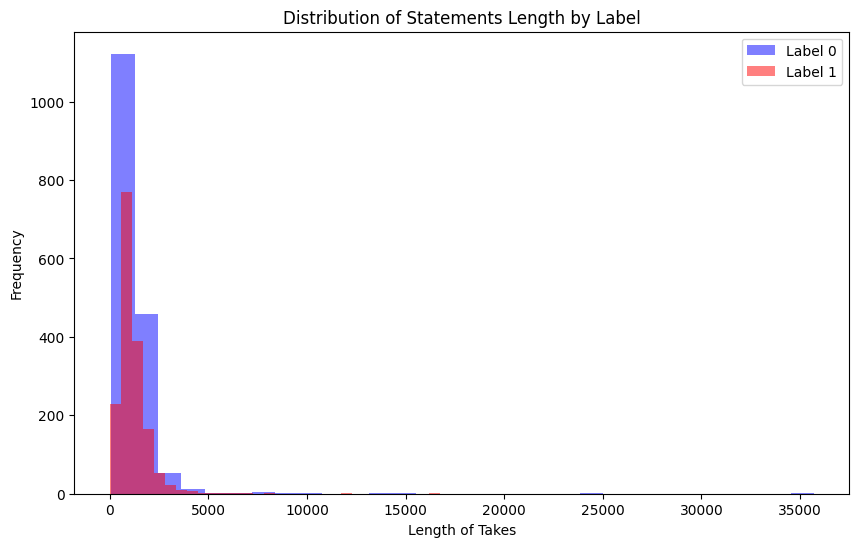

In [10]:
df_improvement_1['Length'] = df_improvement_1["Statements"].apply(len)

length_label_0 = df_improvement_1[df_improvement_1['Labels'] == 0]['Length']
length_label_1 = df_improvement_1[df_improvement_1['Labels'] == 1]['Length']

plt.figure(figsize=(10, 6))
plt.hist(length_label_0, bins=30, alpha=0.5, color='blue', label='Label 0')
plt.hist(length_label_1, bins=30, alpha=0.5, color='red', label='Label 1')
plt.xlabel('Length of Takes')
plt.ylabel('Frequency')
plt.title('Distribution of Statements Length by Label')
plt.legend()
plt.show()

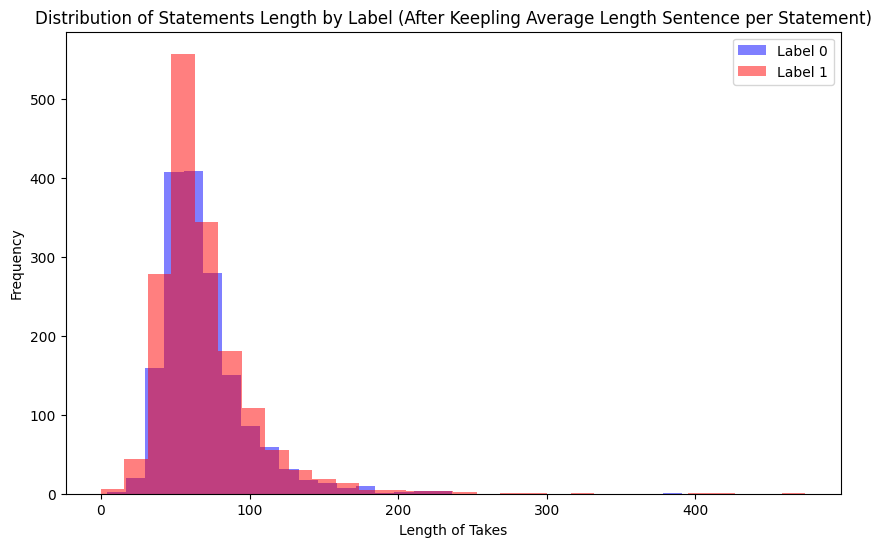

In [11]:
def extract_average_length_sentence(statement):
    sentences = re.findall(r'[A-Z][^\.]*\.', statement)
    if not sentences:
        return statement
    avg_length = sum(len(sentence) for sentence in sentences) / len(sentences)
    return min(sentences, key=lambda s: abs(len(s) - avg_length))

df_improvement_analyse = df_improvement_1.copy()
df_improvement_analyse["Statements"] = df_improvement_analyse["Statements"].apply(extract_average_length_sentence)
df_improvement_analyse["Length"] = df_improvement_analyse["Statements"].apply(len)

length_label_0 = df_improvement_analyse[df_improvement_analyse['Labels'] == 0]['Length']
length_label_1 = df_improvement_analyse[df_improvement_analyse['Labels'] == 1]['Length']

plt.figure(figsize=(10, 6))
plt.hist(length_label_0, bins=30, alpha=0.5, color='blue', label='Label 0')
plt.hist(length_label_1, bins=30, alpha=0.5, color='red', label='Label 1')
plt.xlabel('Length of Takes')
plt.ylabel('Frequency')
plt.title('Distribution of Statements Length by Label (After Keepling Average Length Sentence per Statement)')
plt.legend()
plt.show()

In [12]:
df_syntax = df_improvement_1.copy()

def get_syntax_features(text):
    doc = nlp(text)
    length = len(doc)
    if length == 0:
        return {}
    
    pos_counts = Counter(token.pos_ for token in doc)
    pos_ratios = {f"ratio_{pos}": count / length for pos, count in pos_counts.items()}
    def get_depth(token):
        depth = 0
        current = token
        while current.head != current:
            current = current.head
            depth += 1
        return depth
    
    depths = [get_depth(t) for t in doc]
    avg_depth = sum(depths) / len(depths) if depths else 0
    
    features = {
        "nb_tokens": length,
        "avg_dep_depth": avg_depth,
        **pos_ratios
    }
    return features

syntax_data = []
for i, row in df_syntax.iterrows():
    feats = get_syntax_features(row["Statements"])
    feats["Labels"] = row["Labels"]
    syntax_data.append(feats)

df_syntax_feats = pd.DataFrame(syntax_data).fillna(0)

df_mean_syntax = df_syntax_feats.groupby("Labels").mean()

In [13]:
print(df_mean_syntax)

         nb_tokens  avg_dep_depth  ratio_PRON  ratio_AUX  ratio_VERB  \
Labels                                                                 
0       287.592414       2.203000    0.146869   0.070127    0.134431   
1       249.693558       2.483585    0.159781   0.071502    0.141182   

        ratio_DET  ratio_NUM  ratio_ADJ  ratio_NOUN  ratio_ADP  ratio_PUNCT  \
Labels                                                                        
0         0.06199   0.012906   0.056275    0.129541   0.071334     0.143582   
1         0.04336   0.010991   0.051478    0.121897   0.080252     0.113045   

        ratio_CCONJ  ratio_ADV  ratio_PART  ratio_PROPN  ratio_SYM  \
Labels                                                               
0          0.034825   0.052729    0.029958     0.033471   0.000776   
1          0.027474   0.079424    0.028180     0.031329   0.000798   

        ratio_SCONJ  ratio_INTJ  ratio_SPACE   ratio_X  
Labels                                                  

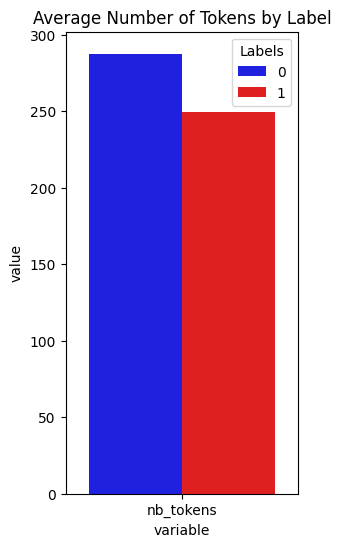

In [14]:
features_to_plot = ["nb_tokens"]
df_plot = df_mean_syntax[features_to_plot].reset_index().melt(id_vars="Labels")

plt.figure(figsize=(3,6))
sns.barplot(data=df_plot, x="variable", y="value", hue="Labels", palette=["blue","red"])
plt.xticks(rotation=0)
plt.title("Average Number of Tokens by Label")
plt.show()

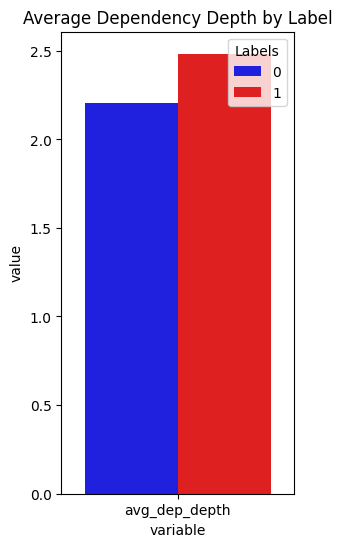

In [15]:
features_to_plot = ["avg_dep_depth"]
df_plot = df_mean_syntax[features_to_plot].reset_index().melt(id_vars="Labels")

plt.figure(figsize=(3,6))
sns.barplot(data=df_plot, x="variable", y="value", hue="Labels", palette=["blue","red"])
plt.xticks(rotation=0)
plt.title("Average Dependency Depth by Label")
plt.show()

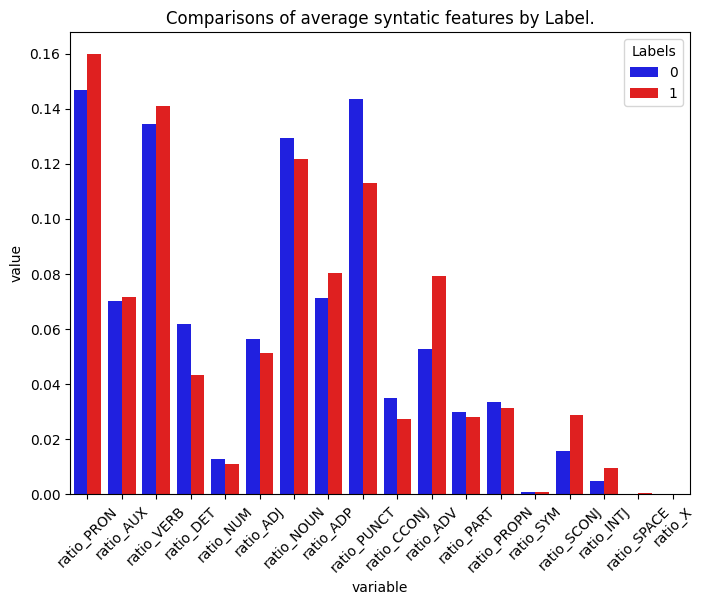

In [16]:
features_to_plot = df_mean_syntax.columns[df_mean_syntax.columns.str.startswith("ratio_")]
df_plot = df_mean_syntax[features_to_plot].reset_index().melt(id_vars="Labels")

plt.figure(figsize=(8,6))
sns.barplot(data=df_plot, x="variable", y="value", hue="Labels", palette=["blue","red"])
plt.xticks(rotation=45)
plt.title("Comparisons of average syntatic features by Label.")
plt.show()

/tmp/ipykernel_803053/4288399732.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_diversity, x="Labels", y="lexical_diversity", palette=["blue","red"])


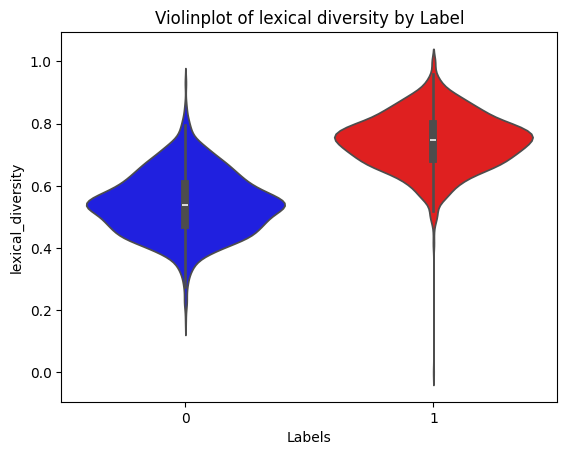

In [17]:
def lexical_diversity(text):
    tokens = re.findall(r"\w+", text.lower())
    if not tokens:
        return 0
    return len(set(tokens)) / len(tokens)

df_diversity = df_improvement_1.copy()
df_diversity["lexical_diversity"] = df_diversity["Statements"].apply(lexical_diversity)

sns.violinplot(data=df_diversity, x="Labels", y="lexical_diversity", palette=["blue","red"])
plt.title("Violinplot of lexical diversity by Label")
plt.show()


In [18]:
thank_count_label_0 = df_improvement_1[df_improvement_1['Labels'] == 0]['Statements'].str.lower().str.count(r'\bthank\b').sum()
thank_count_label_1 = df_improvement_1[df_improvement_1['Labels'] == 1]['Statements'].str.lower().str.count(r'\bthank\b').sum()

print(f"Occurrences of 'thank' in Labels = 0: {thank_count_label_0}")
print(f"Occurrences of 'thank' in Labels = 1: {thank_count_label_1}")

Occurrences of 'thank' in Labels = 0: 1003
Occurrences of 'thank' in Labels = 1: 3191


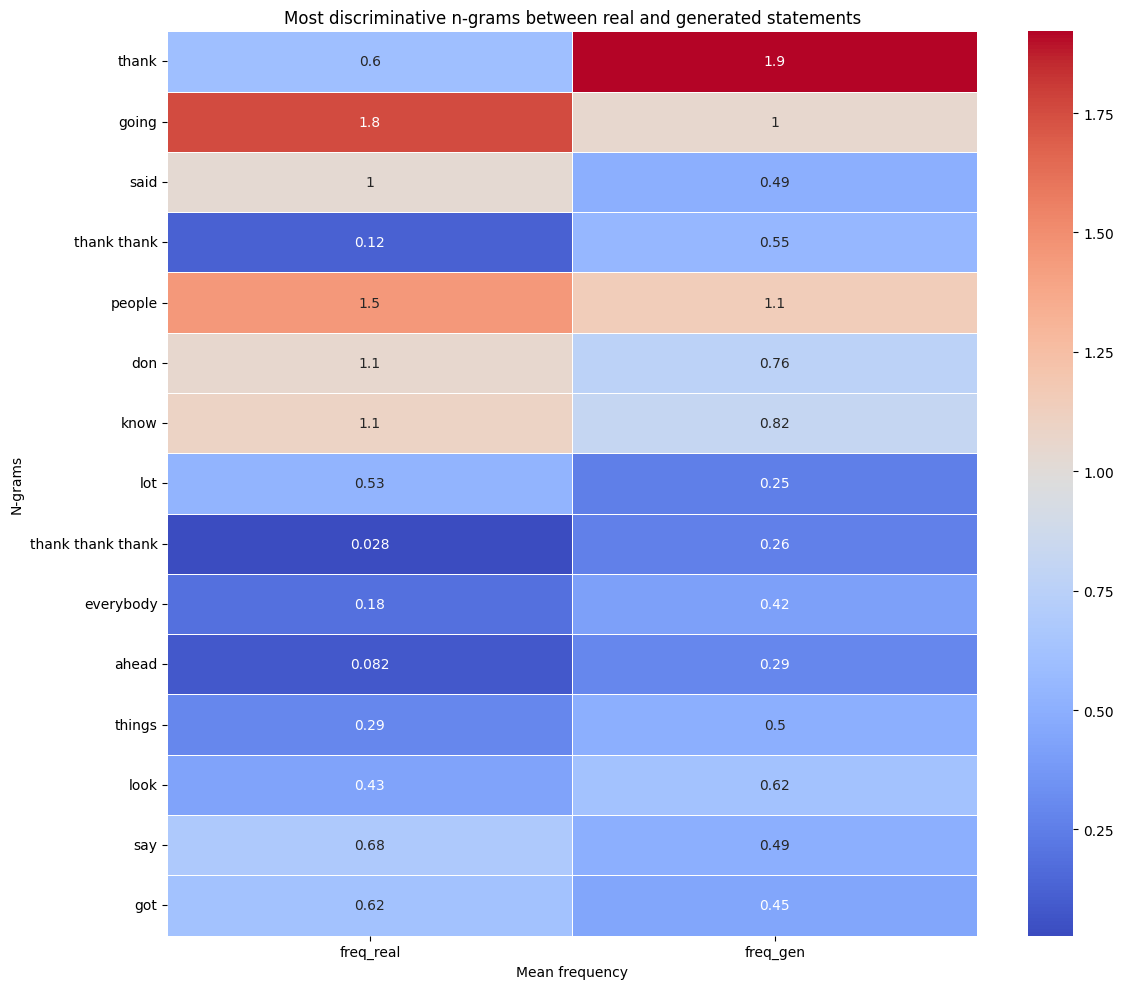

In [19]:
statements_real = df_improvement_1[df_improvement_1['Labels'] == 0]['Statements'].tolist()
statements_gen = df_improvement_1[df_improvement_1['Labels'] == 1]['Statements'].tolist()

n_gram_range = (1, 4)
min_freq = 5
top_n = 15

vectorizer = CountVectorizer(ngram_range=n_gram_range, min_df=min_freq, stop_words='english')
X_all = vectorizer.fit_transform(df_improvement_1["Statements"])
features = vectorizer.get_feature_names_out()

X_real = vectorizer.transform(statements_real)
X_gen = vectorizer.transform(statements_gen)

freq_real = np.asarray(X_real.mean(axis=0)).flatten()
freq_gen = np.asarray(X_gen.mean(axis=0)).flatten()

df_freq = pd.DataFrame({
    "ngram": features,
    "freq_real": freq_real,
    "freq_gen": freq_gen,
})

df_freq["discriminative_score"] = np.abs(df_freq["freq_gen"] - df_freq["freq_real"])

df_top_discriminative = df_freq.sort_values("discriminative_score", ascending=False).head(top_n)

heatmap_data = df_top_discriminative.set_index("ngram")[["freq_real", "freq_gen"]]

plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Most discriminative n-grams between real and generated statements")
plt.ylabel("N-grams")
plt.xlabel("Mean frequency")
plt.tight_layout()
plt.show()
